In [ ]:
!pip install -U bitsandbytes transformers accelerate

In [ ]:
from google.colab import drive, files
drive.mount('/content/drive')

In [ ]:
# Make sure to upload utils.py
files.upload()

In [1]:
import os
import sys

path = os.getcwd()
while True:
    if 'utils.py' in os.listdir(path):
        if path not in sys.path:
            sys.path.append(path)
        break
    new_path = os.path.dirname(path)
    if new_path == path:
        print("utils.py not found in any parent folder.")
        break
    path = new_path

import utils
import pandas as pd
from torch.utils.data import DataLoader
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
import torch


c:\Users\User\anaconda3\envs\nlp\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
utils.hf_login("HF_TOKEN")

Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


In [ ]:
quantization_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.bfloat16,
    bnb_4bit_quant_type="nf4"
)

In [ ]:
model_id = 'mistralai/Mistral-7B-Instruct-v0.3'

tokenizer = AutoTokenizer.from_pretrained(model_id)
model = AutoModelForCausalLM.from_pretrained(
    model_id,
    device_map="auto",
    quantization_config=quantization_config,
    attn_implementation="eager"
    )

In [4]:
# files.upload()
scitail_test = pd.read_csv('../../../Datasets/Scitail/scitail_test.csv')

In [1]:
scitail_test.info()

NameError: name 'scitail_test' is not defined

In [ ]:
scitail_test.head()

In [ ]:
# Find the max_length for tokenization to avoid wasting computing.
utils.find_max_length(scitail_test, tokenizer=tokenizer, dataset_type='scitail')

In [ ]:
# Define dataset and create a dataloader.
dataset_test = utils.MyDataset(dataframe=scitail_test,
                               tokenizer=tokenizer,
                               dataset_type='scitail',
                               prompt_max_length=117,
                               label_max_length=3)

batch_size = 16 # Change batch size according to GPU
dataloader = DataLoader(dataset_test, batch_size=batch_size, shuffle=False) 

In [ ]:
# # Test
# from importlib import reload
# reload(utils)
# predictions, gold_labels, batch_probs = utils.test_run(model=model,
#                                                        dataloader=dataloader,
#                                                        tokenizer=tokenizer,
#                                                        dataset_type='scitail')


In [ ]:
# Create checkpoint
checkpoint_dir = "/content/drive/MyDrive/eval_checkpoints"
os.makedirs(checkpoint_dir, exist_ok=True)
print("Checkpoint directory:", checkpoint_dir)

checkpoint_path = os.path.join(
    checkpoint_dir,
    f"checkpoint_scitail_{model_id.split('/')[1]}.pt".replace('-', '_')
)

In [5]:
checkpoint_path = utils.create_checkpoint_path(model_id='mistralai/Mistral-7B-Instruct-v0.3', name='scitail')

Saving to: c:\Users\User\Desktop\DAMA_EAP\NLI_Study\Notebooks\Scitail_Notebooks\Scitail-Mistral-7B-Instruct-v0.3-zero-shot\checkpoint_scitail_Mistral_7B_Instruct_v0.3.pt


In [ ]:
from tqdm import tqdm

# Load checkpoint if it exists
predicted_labels, gold_labels, start_batch = utils.load_checkpoint(checkpoint_path=checkpoint_path)
labels = utils.get_labels('scitail')

# Loop over the batches
with torch.no_grad():
    for i, batch in enumerate(tqdm(dataloader, desc="Evaluating", unit="batch")):

        # Continue from last checkpoint
        if i < start_batch:
            continue

        input_ids_batch = batch["input_ids"].to(model.device) # Move to GPU
        attention_mask_batch = batch["attention_mask"].to(model.device) # Move to GPU
        gold_labels_batch = batch["labels"] # Keep to CPU

        batch_probs = utils.get_model_probs(input_ids=input_ids_batch,
                                            attention_mask=attention_mask_batch,
                                            dataset_type='scitail',
                                            model=model,
                                            tokenizer=tokenizer)
        
        batch_pred_indices = torch.argmax(batch_probs, dim=1)
        batch_pred_labels = [labels[i] for i in batch_pred_indices]

        predicted_labels.extend(batch_pred_labels)
        gold_labels.extend(gold_labels_batch)

        # Save checkpoint
        if i % 50 == 0 or i == len(dataloader) - 1:
            torch.save({"predicted_labels": predicted_labels,
                        "gold_labels": gold_labels,
                        "batch_no": i+1}, checkpoint_path)

            print(f"Checkpoint saved: {i+1}, {checkpoint_path}")

In [7]:
predicted_labels, gold_labels, _ = utils.load_checkpoint(checkpoint_path=checkpoint_path)

Checkpoint found.


Accuracy: 0.7822.
 F1 Score: 0.5254.
 Matthew's Correlation Coefficient: 0.5912.
 Cohen's Kappa Score: 0.5747.


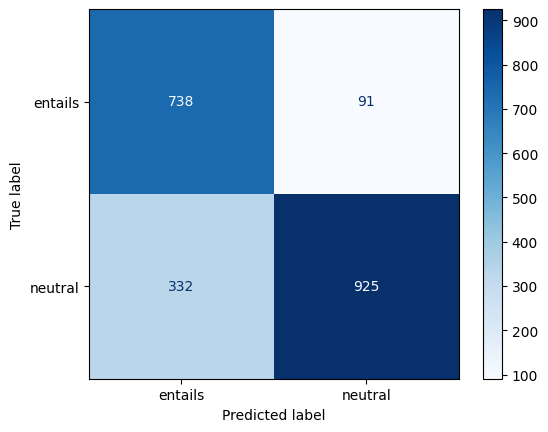

In [8]:
# Calculate metrics
# from importlib import reload
# reload(utils)
utils.evaluate_metrics(predicted_labels=predicted_labels, gold_labels=gold_labels, dataset_type='scitail')

# <center> Explainability <center>

In [ ]:
# Application of Lime
from lime.lime_text import LimeTextExplainer

class_names = utils.get_labels('scitail')
explainer = LimeTextExplainer(class_names=class_names)

In [ ]:
# Wrapper function for Lime
def predict_fn(texts, model=model, tokenizer=tokenizer, dataset_type='scitail'):
    inputs = tokenizer(texts, return_tensors="pt", padding=True, truncation=True).to(model.device)
    probs = utils.get_model_probs(inputs['input_ids'], inputs['attention_mask'], model, tokenizer, dataset_type)
    probs = probs / probs.sum(dim=1, keepdim=True)
    return probs.cpu().numpy()

In [ ]:
# One example
tokenizer.pad_token = tokenizer.eos_token
text_instance = dataset_test[0]['prompt'] + ' ' + dataset_test[0]['labels']
exp = explainer.explain_instance(text_instance,
                                 predict_fn, 
                                 num_features=6, 
                                 num_samples=250)
exp.show_in_notebook()